# Analysis of Gradient Descent and It's Variants

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
from typing import List, Tuple, Set, Dict, Type
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from sklearn import datasets as dsets

print('')

In [78]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

Remember the formulation for gradient descent:

$$\beta_{t+1} = \beta_t - \eta\nabla e(\textbf{X}, \textbf{y}, \beta_t)$$

where $e: \mathbb{R}^m \rightarrow \mathbb{R}$ is an error function, $\textbf{D} = (\textbf{X}, \textbf{y})$ is the __entire__ dataset, $\eta$ is a fixed step size (also called the __learning rate__) that was decided __before__ training), and $\beta_j$ are the learnable parameters of the model at iteration $j$.

One question that comes to mind is "what happens if our dataset $\textbf{D}$ is too big to load into memory?"

## Stochastic Gradient Descent

Idea: Break up $\textbf{D}$ into __batches__, each containing $k$ examples, and update our parameters for each batch (using normal gradient descent)

In [79]:
def SGD(X: np.ndarray, Y: np.ndarray, lr: float, k: int, e):
    while not converged and not train_too_long:
        randomly construct (X1, Y1), (X2, Y2), ..., (Xm, Ym) from X,Y with batch_size k
        for Xi, Yi in (X1, Y1), (X2, Y2), ..., (Xm, Ym):
            beta = beta - lr*grad(e)
        shuffle(X, Y)
        converged = ...
        train_too_long = ...
        
def GD(X: np.ndarray, Y: np.ndarray, lr: float, k: int, e):
    while not converged and not train_too_long:
        randomly construct (X1, Y1), (X2, Y2), ..., (Xm, Ym) from X,Y with batch_size k
        grad = zeros(...)
        for Xi, Yi in (X1, Y1), ..., (Xm, Ym):
            grad += sum_over_rows(Jacobian(Xi, Yi))
        beta = beta - lr*grad
        shuffle(X, Y)
        converged = ...
        train_too_long = ...

SyntaxError: invalid syntax (<ipython-input-79-9d6a9905fb8f>, line 3)

The most extreme version of this is when the $k=1$. In this example (also called __vanilla__ stochastic gradient descent), the model is updated for __each training example__ separately. There is also a (more popular) version of this called __minibatch__ stochastic gradient descent, were $1 < k < |\textbf{D}|$. Let's look at the convergence of vanilla gradient descent, and also with stochastic gradient descent.

$\textit{Claim}$: Let us say error function $e: \mathbb{R}^{m} \rightarrow \mathbb{R}$ is convex and differentiable, and that $\nabla e$ is __Lipschitz__ continuous with minimum Lipschitz constant $c > 0$. If $\eta \le \frac{2}{c}$, then gradient descent is guaranteed to converge.

Side note: function $f$ is __Lipschitz__ continuous with constant $k > 0$ if $\forall \textbf{x},\textbf{y} \hspace{0.5cm}||f(\textbf{x}) - f(\textbf{y})||_2 \le k||\textbf{x}-\textbf{y}||_2$
Think of it this way: for every pair of points, $f$ is bounded on how fast it can change by $k$. Check out this gif (from https://en.wikipedia.org/wiki/Lipschitz_continuity).

In [80]:
HTML('<img src="./figs/lipschitz_cont.gif">')

$\textit{Proof}$: Since we know $e$ is convex, we know (using a 2nd degree Taylor polynomial of $e$ centered around $e(\textbf{x})$):
$$e(\textbf{y}) \le e(\textbf{x}) + \nabla e(\textbf{x})^T(\textbf{y}-\textbf{x})  + \frac{1}{2}\nabla^2 e(\textbf{x})(\textbf{y}-\textbf{x})(\textbf{y}-\textbf{x})^T$$

Since $\nabla e$ is Lipschitz continuous with minimum constant $c$, we know the following bound on how much $\nabla e$ can change (i.e. a bound on the slope of $\nabla e$ which is $\nabla^2 e$):
$$\nabla^2 e(\textbf{x}) \le c\textbf{I}$$

which changes our expression into:
$$e(\textbf{y}) \le e(\textbf{x}) + \nabla e(\textbf{x})^T(\textbf{y}-\textbf{x})  + \frac{1}{2}c\textbf{I}(\textbf{y}-\textbf{x})(\textbf{y}-\textbf{x})^T$$

At this point, let us say the point $\textbf{y}$ is our new point $\textbf{x}_{t+1}$ computed as one iteration of gradient descent (i.e. $\textbf{x}_{t+1} = \textbf{x}_t - \eta\nabla e(\textbf{x}_t)$):
$$\begin{align}
    e(\textbf{x}_{t+1}) &\le& e(\textbf{x}_t) + \nabla e(\textbf{x}_t)^T(\textbf{x}_t - \eta\nabla e(\textbf{x}_t)-\textbf{x}_t)  + \frac{1}{2}c\textbf{I}(\textbf{x}_t - \eta\nabla e(\textbf{x}_t)-\textbf{x}_t)(\textbf{x}_t - \eta\nabla e(\textbf{x}_t)-\textbf{x}_t)^T\\
    &=& e(\textbf{x}_t) - \eta\nabla e(\textbf{x}_t)^T\nabla e(\textbf{x}_t) + \frac{1}{2}c\eta^2\textbf{I}\nabla e(\textbf{x}_t) \nabla e(\textbf{x}_t)^T\\
    &=& e(\textbf{x}_t) - \eta||\nabla e(\textbf{x}_t)||_2^2 + \frac{1}{2}c\eta^2||\nabla e(\textbf{x}_t)||_2^2\\
    &=& e(\textbf{x}_t) - (1 - \frac{1}{2}c\eta)\eta||\nabla e(\textbf{x}_t)||_2^2
\end{align}$$

Whew! Lots of work there, but we're almost done.

Since we know $||\nabla e(\textbf{x}_t)||_2^2 \ge 0$ and $\eta > 0$, then $e(\textbf{x}_{t+1}) \le e(\textbf{x}_t) \leftrightarrow -(1 - \frac{1}{2}c\eta) \le 0$:
$$\begin{align}
    \frac{1}{2}c\eta - 1 &\le& 0\\
    \eta \le \frac{2}{c}\\
\end{align}$$


This isn't very good, because this means our choice of $\eta$ is tied to the model and error function. What if we use a model that is not lipschitz continuous? It would be much better if $\eta$ was independent (from the model and error function).

What about stochastic gradient descent?

$\textit{Setup}$: gradient descent is all about computing the __overall__ gradient for the entire dataset. Remember, we compute this by summing over the columns of the jacobian matrix (assuming $m$ training examples in dataset $\textbf{D}$):
$$\nabla e = \frac{1}{n}\textbf{1}^T\textbf{J}$$

This can be written as:
$$\nabla e(\textbf{X}, \textbf{Y}, \beta) = \frac{1}{n}\sum\limits_{i=1}^{n} \nabla e(\textbf{X}_i, \textbf{Y}_i, \beta)$$

in stochastic gradient descent, we are computing:
$$\nabla e(\textbf{X}_{j}, \textbf{Y}_j, \beta) = \frac{1}{|\textbf{X}_j|}\sum\limits_{i=1}^{|\textbf{X}_j|} \nabla e(\textbf{X}_{j,i}, \textbf{Y}_{j,i}, \beta)$$
where $\textbf{X}_{j}, \textbf{Y}_j$ is the $j^{th}$ batch of data ($d = \lceil\frac{m}{k}\rceil$ total) and has size $|\textbf{X}_j| \le k$

__Important__: Each time we update parameters, we randomly choose $j$

Because of this randomness, we are interested in $\mathbb{E}\Big[\nabla e(\textbf{X}_j, \textbf{Y}_j, \beta)\Big]$

Lets talk about __vanilla__ SGD for a second:
$$\begin{align}
    \mathbb{E}\Big[\nabla e(\textbf{X}_j, \textbf{Y}_j, \beta)\Big] &=& \sum\limits_{i=1}^{n} \nabla e(\textbf{X}_i, \textbf{Y}_i)Pr(\textbf{X}_i, \textbf{Y}_i, \beta)\\
    &=& \sum\limits_{i=1}^{n} \nabla e(\textbf{X}_i, \textbf{Y}_i, \beta)\frac{1}{n}\\
    &=& \frac{1}{n}\sum\limits_{i=1}^{n} \nabla e(\textbf{X}_i, \textbf{Y}_i, \beta)\\
    &=& \nabla e(\textbf{X}, \textbf{Y}, \beta)
\end{align}$$

Woooo!! If we use __vanilla__ SGD, we are still computing an __unbiased__ estimate of the gradient at each step!

What about __minibatch__ SGD?

$$\begin{align}
    \mathbb{E}\Big[\frac{1}{\textbf{X}_j}\nabla e(\textbf{X}_j, \textbf{Y}_j, \beta)\Big] &=& \sum\limits_{j=1}^{d}Pr(\textbf{X}_{j}, \textbf{Y}_{j})\frac{1}{|\textbf{X}_j|}\sum\limits_{i=1}^{|\textbf{X}_j|} \nabla e(\textbf{X}_{j,i}, \textbf{Y}_{j,i}, \beta)\\
    &=& \sum\limits_{j=1}^{d}\frac{1}{d}\frac{1}{|\textbf{X}_j|}\sum\limits_{i=1}^{|\textbf{X}_j|} \nabla e(\textbf{X}_{j,i}, \textbf{Y}_{j,i}, \beta)\\
    &=& \sum\limits_{j=1}^{d}\frac{k}{n}\frac{1}{k}\sum\limits_{i=1}^{k} \nabla e(\textbf{X}_{j,i}, \textbf{Y}_{j,i}, \beta)\\
    &=& \sum\limits_{j=1}^{d}\sum\limits_{i=1}^{k} \nabla e(\textbf{X}_{j,i}, \textbf{Y}_{j,i}, \beta)\\
    &=& \sum\limits_{z=1}^{n} \nabla e(\textbf{X}_{z}, \textbf{Y}_{z}, \beta)\\
    &=& \nabla e(\textbf{X}, \textbf{Y}, \beta)
\end{align}$$

In [4]:
# code to make minibatches
def make_minibatches(X: np.ndarray, Y: np.ndarray, minibatch_size: int) -> Tuple[np.ndarray, np.ndarray]:
    # sanity check
    assert(X.shape[0] == Y.shape[0]) # should have same number of example
    assert(minibatch_size > 0)
    assert(minibatch_size <= X.shape[0])
    if minibatch_size == X.shape[0]:
        yield X, Y

    else:
        # randomly shuffle the data
        minibatch_ids: np.ndarray = np.random.randint(low=0, high=minibatch_size,
                                                      size=np.ceil(X.shape[0] / minibatch_size))
        for i in minibatch_ids:
            yield X[minibatch_ids==i,:], Y[minibatch_ids==i,:]
            
def yield_ex(x: int) -> int:
    for i in range(x):
        print(i)
        yield i
        
for i in yield_ex(10):
    print("main loop body")

0
main loop body
1
main loop body
2
main loop body
3
main loop body
4
main loop body
5
main loop body
6
main loop body
7
main loop body
8
main loop body
9
main loop body


But what about that $\eta$?

There are plenty of variants on SGD, we will only talk about three of them: __momentum__, __rmsprop__, and __adam__. All three of these methods use the gradient descent paradigm (compute gradients, update guess iteratively), however they focus on effectively changing the update.

## Momentum optimization

Momentum does not actually change $\eta$, instead it adds an extra term onto the update step:
$$\beta_{t+1} = \beta_t + \triangle\beta_t$$

Where $\triangle\beta_t = \alpha\triangle\beta_{t-1} - \eta\nabla e$ is the change in $\beta$ from the last update step. Given a parameter $\alpha \ge 0$, momentum encourages the current update step to consider the previous update step as well. This method prevents $\beta$ from changing sharply, because $\alpha\triangle\beta_t$ smooths out any sharp changes in direction.

## RMSProp (Root Mean Squared Propogation) optimization

This method makes two conceptual differences from what we have talked about so far. Instead of using one $\eta$ shared across all parameters (i.e. each parameter is updated by the same constant step size), why not give each parameter a separate step size that can change?

RMSProp divides the learning rate for each parameter by the running average of the magnitudes of the gradients for that parameter. In other words, keep a running total of how much a parameter has changed (i.e. the magnitude of its gradient at each iteration), and scale the learning rate for that parameter by the running total:

$$\begin{align}
    \textbf{v}_{t+1} = \alpha\textbf{v}_{t} + (1-\alpha)\textbf{I}\nabla e\nabla e^T\\
    \beta_{t+1} = \beta_t - \frac{\eta}{\sqrt{\textbf{v}_{t+1}}}\nabla e\\
\end{align}$$

## Adam (Adaptive Moment Estimation) optimization

Adam is built on top of RMSProp, and uses both the first and second moments (avg and variance respectively) to compute the scaling for each parameter's learning rate:

$$\begin{align}
    \textbf{m}_{t+1} = \alpha_1\textbf{m}_{t} + (1-\alpha_1)\nabla e\\
    \textbf{v}_{t+1} = \alpha_2\textbf{v}_{t} + (1-\alpha_2)\textbf{I}\nabla e\nabla e^T\\
    \hat{\textbf{m}}_{t+1} = \frac{\textbf{m}_{t+1}}{1 - \alpha_1^{t+1}}\\
    \hat{\textbf{v}}_{t+1} = \frac{\textbf{v}_{t+1}}{1-\alpha_2^{t+1}}\\
    \beta_{t+1} = \beta_t - \eta\frac{\hat{\textbf{m}}_{t+1}}{\sqrt{\hat{\textbf{v}}_{t+1}} + \epsilon}
\end{align}$$

Just like when proving convergence for SGD, we care about $\mathbb{E}\Big[\textbf{m}_t\Big]$ and $\mathbb{E}\Big[\textbf{v}_t\Big]$. Lets focus on just one, since the way they are computed is identical:

$$\begin{align}
  \mathbb{E}\Big[\textbf{m}_t\Big] &=& \mathbb{E}\Big[(1-\alpha_1)\sum\limits_{i=0}^t \alpha_1^{t-i}\nabla e_i\Big]\\
  &=& (1-\alpha_1)\mathbb{E}\Big[\nabla e_t\Big]\Big(\sum\limits_{i=1}^t \alpha_1^{t-i}\Big) + C\\
  &=& (1-\alpha_1^t)\mathbb{E}\Big[\nabla e_t\Big] + C
\end{align}$$

This is a biased estimator, so we correct it by computing $\hat{\textbf{m}}_t = \frac{\textbf{m}_t}{1-\alpha_1^t}$

## Computing Gradients

I know we talked last lecture about __how__ to actually compute these gradients (using the chain rule), but I really want to cement this process. Lets think of the computing the error for a model using an arbitrary model and error function:

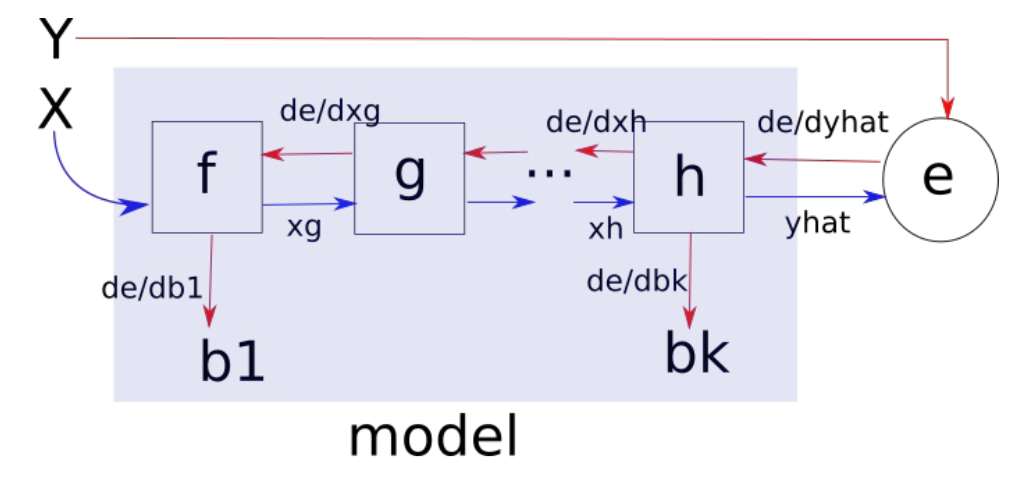

In [82]:
sl.hide_code_in_slideshow()
display(Image("figs/model_error_computation.png", width=850))

The algorithm that efficiently computes this is called the __backpropagation__ algorithm. Before we can show/use/implement the algorithm, we need to introduce a new model type other than linear regression. For now, lets just talk about feed forwared neural networks.

## Feed Forward Neural Networks

The Linear Regression we've talked about computes $\textbf{y} = [\textbf{X}, \textbf{1}]\beta$, and predicts a single number per example. Neural networks work in a similar fashion, but with a few differences:

  - Neural networks compute $\textbf{Y} = f([\textbf{X}, \textbf{1}])\textbf{W}$ where $f: \mathbb{R}^{k}\rightarrow \mathbb{R}^{k}$ is some activation function (typically nonlinear).
  - $\textbf{W}\in \mathbb{R}^{(n+1)\times k}$, is a __matrix__ instead of a vector (i.e. you have the ability to predict more than a single number per example).
  - This means the output $\textbf{Y}\in \mathbb{R}^{m\times k}$ does not have to be a vector.
  
Feed forward are just the above computation (although there are many, many types of neural networks), and are typically stacked into layers like the diagram earlier.

For now, we're going to restrict ourselves to only talking about __element-wise independent__ activation functions. This means that $f(\textbf{x}) = [f(x_1), f(x_2), \dots, f(x_n)]$

There are __non element-wise independent__ activation functions (ex. softmax) and computing their jacobian is significantly harder. I will include just softmax in our implementation, but we will only discuss __element-wise independent__ functions.

element-wise indepdence is nice for computing jacobians. If $f(\textbf{x}) = [f(x_1), f(x_2), \dots, f(x_n)]$, then $\frac{\partial f(\textbf{x})}{\partial x_j} = f'(x_j)$, so $\nabla f = [f'(x_1), f'(x_2), \dots, f'(x_n)]$

In [3]:
# base class of all computation modules
from abc import ABC, abstractmethod
class Module(ABC):
    @abstractmethod
    def forward(self, X: np.ndarray) -> np.ndarray:
        ...

    @abstractmethod
    def backward(self, X: np.ndarray, dE_dModule: np.ndarray) -> np.ndarray:
        ...

In [4]:
# some activation functions
class Sigmoid(Module):
    def forward(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-X))

    def backward(self, X: np.ndarray, dE_dModule: np.ndarray) -> np.ndarray:
        Y_hat: np.ndarray = self.forward(X)
        dModule_dX: np.ndarray = Y_hat*(1 - Y_hat)
        return np.multiply(dE_dModule, dModule_dX)

    
class Tanh(Module):
    def forward(self, X: np.ndarray) -> np.ndarray:
        return np.tanh(X)

    def backward(self, X: np.ndarray, dE_dModule: np.ndarray) -> np.ndarray:
        dModule_dX: np.ndarray = 1 - self.forward(X)**2
        return np.multiply(dE_dModule, dModule_dX)

class Linear(Module):
    def forward(self, X: np.ndarray) -> np.ndarray:
        return X

    def backward(self, X: np.ndarray, dE_dModule: np.ndarray) -> np.ndarray:
        return dE_dModule

In [5]:
# some error functions
class ErrorFunc(ABC):
    @staticmethod
    @abstractmethod
    def forward(Y_hat: np.ndarray, Y_gt: np.ndarray) -> float:
        ...
    
    @staticmethod
    @abstractmethod
    def backward(Y_hat: np.ndarray, Y_gt: np.ndarray) -> np.ndarray:
        ...

        
class MSE(ErrorFunc):
    @staticmethod
    def forward(Y_hat: np.ndarray, Y_gt: np.ndarray) -> float:
        assert(Y_hat.shape == Y_gt.shape)
        return np.sum((Y_hat - Y_gt)**2)/(2*Y_hat.shape[0])

    @staticmethod
    def backward(Y_hat: np.ndarray, Y_gt: np.ndarray) -> np.ndarray:
        assert(Y_hat.shape == Y_gt.shape)
        return (Y_hat - Y_gt)/Y_hat.shape[0]

In [6]:
# our parameter class
class Parameter(object):
    def __init__(self, V: np.ndarray) -> np.ndarray:
        self.val: np.ndarray = V
        self.grad: np.ndarray = None

    def reset(self) -> "Parameter":
        self.grad = np.zeros_like(self.val)

    def step(self, G: np.ndarray) -> "Parameter":
        self.val -= G
        return self.reset()

In [7]:
# our feed forward neural network class
class Dense(Module):
    def __init__(self, in_dim: int, out_dim: int, af: Type[Module] = None) -> None:
        self.W: Parameter = Parameter(np.random.randn(in_dim, out_dim))
        self.b: Parameter = Parameter(np.random.randn(1, out_dim))
        self.af: Type[Module] = af
        if self.af is None:
            self.af = Sigmoid

    def params(self) -> List[Parameter]:
        return [self.W, self.b]

    def forward(self, X: np.ndarray) -> np.ndarray:
        return self.af.forward(np.dot(X, self.W.val) + self.b.val)

    def backward(self, X: np.ndarray, dE_dModule: np.ndarray) -> np.ndarray:
        Z: np.ndarray = np.dot(X, self.W.val) + self.b.val
        # A: np.ndarray = self.af.forward(Z)

        dE_dZ: np.ndarray = self.af.backward(Z, dE_dModule)
        self.W.grad += np.dot(X.T, dE_dZ)
        self.b.grad += np.sum(dE_dZ, axis=0, keepdims=True)

        dZ_dX: np.ndarray = self.W.val.T
        return np.dot(dE_dZ, dZ_dX)

In [8]:
# our sequential modl
class Sequential(Module):
    def __init__(self, layers: List[Module] = None) -> None:
        self.layers: List[Module] = layers
        if self.layers is None:
            self.layers = list()
        
    def add(self, m: Module) -> "Sequential":
        self.layers.append(m)
        return self

    def params(self) -> List[Parameter]:
        params: List[Parameter] = list()
        for l in self.layers:
            params += l.params()
        return params

    def forward(self, X: np.ndarray) -> np.ndarray:
        for l in self.layers:
            X = l.forward(X)
        return X

    def backward(self, X: np.ndarray, dE_dModule: np.ndarray) -> np.ndarray:
        # predict first
        Xs: List[np.ndarray] = [X]
        for l in self.layers:
            X = l.forward(X)
            Xs.append(X)

        for i,l in enumerate(self.layers[::-1]): # traverse backwards
            dE_dModule = l.backward(Xs[-i-2], dE_dModule)
        return dE_dModule

In [9]:
# our optimizers
class Optimizer(ABC):
    def __init__(self, params: List[Parameter]) -> None:
        self.params: List[Parameter] = params

    def reset(self) -> None:
        for P in self.params:
            P.reset()

    @abstractmethod
    def step(self) -> None:
        ...

class SGD(Optimizer):
    def __init__(self, params: List[Parameter], lr: float) -> None:
        super().__init__(params)
        self.lr: float = lr

    def step(self) -> None:
        for P in self.params:
            P.step(self.lr*P.grad)
            
class SGDMomemtum(Optimizer):
    def __init__(self, params: List[Parameter], lr: float, momentum: float = 0.1) -> None:
        super().__init__(params)
        self.lr: float = lr
        self.momentum: float = momentum
        self.deltas: List[np.ndarray] = [np.zeros_like(P.val) for P in self.params]

    def step(self) -> None:
        for i, P in self.params:
            new_delta: np.ndarray = self.momemtum*self.deltas[i] - self.lr*self.P.grad
            P.step(new_delta)
            self.deltas[i] = new_delta 

In [10]:
# always implement gradient checking!
def check_grads(X: np.ndarray, Y_gt: np.ndarray, m: Module, ef: ErrorFunc,
                epsilon: float = 1e-4, delta: float = 1e-6) -> Tuple[bool, np.ndarray, np.ndarray]:
    params: List[Parameter] = m.params()
    num_grads: List[np.ndarray] = [np.zeros_like(P.val) for P in params]
    sym_grads: List[np.ndarray] = [P.grad for P in params]

    for P, N in zip(params, num_grads):
        for index, v in np.ndenumerate(P.val):
            P.val[index] += epsilon
            N[index] += ef.forward(m.forward(X), Y_gt)

            P.val[index] -= 2*epsilon
            N[index] -= ef.forward(m.forward(X), Y_gt)

            # set param back to normal
            P.val[index] = v
            N[index] /= (2*epsilon)

    norms: np.ndarray = np.array([np.linalg.norm(S-N)/np.linalg.norm(S+N) for S,N in zip(sym_grads, num_grads)])
    failed_grad_mask: np.ndarray = norms > delta
    return np.sum(failed_grad_mask, dtype=bool), failed_grad_mask, norms

In [11]:
# test!
X: np.ndarray = np.array([[0,0],
                          [0,1],
                          [1,0],
                          [1,1]], dtype=float)
Y_gt: np.ndarray = np.array([[1,0],
                             [0,1],
                             [0,1],
                             [1,0]], dtype=float)
m = Sequential()
m.add(Dense(2, 5, af=Sigmoid()))
m.add(Dense(5, 2, af=Sigmoid()))
ef = MSE()
opt = SGD(m.params(), lr=0.01)

for epoch in range(100):
    Y_hat: np.ndarray = m.forward(X)
    loss: float = ef.forward(Y_hat, Y_gt)

    opt.reset()
    m.backward(X, ef.backward(Y_hat, Y_gt))
    failed_grads, mask, norms = check_grads(X, Y_gt, m, ef)
    if failed_grads:
        print("ERROR: at least one parameter failed gradient checking!!!")
        print(failed_grads)
        print(mask)
        print(norms)
    opt.step()
